In [1]:
import os
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from src.models.unet import UNet 
from src.models.att_unet import AttentionUNet

torch.cuda.set_device(0)

In [3]:
def load_data(train=True):

    if train:
        addr = '../datasets/DRISHTI/Drishti-GS1_files/Training/'
    else:
        addr = '../datasets/DRISHTI/Drishti-GS1_files/Test/'

    data = {'images': {}, 'cup_mask': {}, 'OD_mask': {} }
    file_names = [x.split('.')[0] for x in os.listdir(addr+'Images/')]

    for file_name in file_names:
        data['images'][file_name] = cv2.imread(addr+'Images/'+file_name+'.png', cv2.COLOR_BGR2RGB) 
        if train:    
            data['cup_mask'][file_name] = cv2.imread(addr+'GT/'+file_name+'/SoftMap/'+file_name+'_cupsegSoftmap.png', cv2.COLOR_BGR2RGB) 
            data['OD_mask'][file_name] = cv2.imread(addr+'GT/'+file_name+'/SoftMap/'+file_name+'_ODsegSoftmap.png', cv2.COLOR_BGR2RGB) 
        else:
            data['cup_mask'][file_name] = cv2.imread(addr+'Test_GT/'+file_name+'/SoftMap/'+file_name+'_cupsegSoftmap.png', cv2.COLOR_BGR2RGB) 
            data['OD_mask'][file_name] = cv2.imread(addr+'Test_GT/'+file_name+'/SoftMap/'+file_name+'_ODsegSoftmap.png', cv2.COLOR_BGR2RGB) 

    # cv2 crop to 20%
    for file_name in file_names:
        img = data['images'][file_name]
        cup_mask = data['cup_mask'][file_name]
        OD_mask = data['OD_mask'][file_name]

        img = img[img.shape[0]//5:img.shape[0]//5*4, img.shape[1]//5:img.shape[1]//5*4]
        cup_mask = cup_mask[cup_mask.shape[0]//5:cup_mask.shape[0]//5*4, cup_mask.shape[1]//5:cup_mask.shape[1]//5*4]
        OD_mask = OD_mask[OD_mask.shape[0]//5:OD_mask.shape[0]//5*4, OD_mask.shape[1]//5:OD_mask.shape[1]//5*4]

        data['images'][file_name] = img
        data['cup_mask'][file_name] = cup_mask
        data['OD_mask'][file_name] = OD_mask

    return data, file_names

data, file_names = load_data()

In [21]:
def data_augmentation(img, cup_mask, OD_mask):
    # Random horizontal flipping
    if np.random.rand() > 0.5:
        img = np.fliplr(img)
        cup_mask = np.fliplr(cup_mask)
        OD_mask = np.fliplr(OD_mask)

    # Random vertical flipping
    if np.random.rand() > 0.5:
        img = np.flipud(img)
        cup_mask = np.flipud(cup_mask)
        OD_mask = np.flipud(OD_mask)


    # Random rotation
    angle = np.random.randint(0, 360)
    img = np.rot90(img, angle//90)
    cup_mask = np.rot90(cup_mask, angle//90)
    OD_mask = np.rot90(OD_mask, angle//90)

    return img, cup_mask, OD_mask


new_files = []
for file_name in file_names:
    data['images'][file_name+'_aug'], data['cup_mask'][file_name+'_aug'], data['OD_mask'][file_name+'_aug'] = data_augmentation(data['images'][file_name], data['cup_mask'][file_name], data['OD_mask'][file_name])
    new_files.append(file_name+'_aug')

file_names += new_files

In [30]:
class SegmentationDataset(Dataset):
    def __init__(self, data, file_names) -> None:
        super().__init__()
        self.img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((512, 512), antialias=True),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                                    ])
        self.mask_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((512, 512), antialias=True)]) 

    def __len__(self):
        return len(file_names) 

    def __getitem__(self, idx):
        img = self.img_transform(data['images'][file_names[idx]]).float().cuda()
        od_mask = self.mask_transform(data['OD_mask'][file_names[idx]]).float().cuda() / 255.0
        cup_mask = self.mask_transform(data['cup_mask'][file_names[idx]]).float().cuda() / 255.0
        return img, od_mask, cup_mask


In [31]:
# create dataset and dataloader
BATCH_SIZE = 1
dataset = SegmentationDataset(data, file_names)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: torch.Size([1, 3, 512, 512])
Optic Disc Mask shape: torch.Size([1, 1, 512, 512])
Cup Mask shape: torch.Size([1, 1, 512, 512])
Image min: -2.00655460357666 Image max: 1.5468183755874634
Optic Disc Mask min: 0.0 Optic Disc Mask max: 0.00392156932502985
Cup Mask min: 0.0 Cup Mask max: 0.00392156932502985


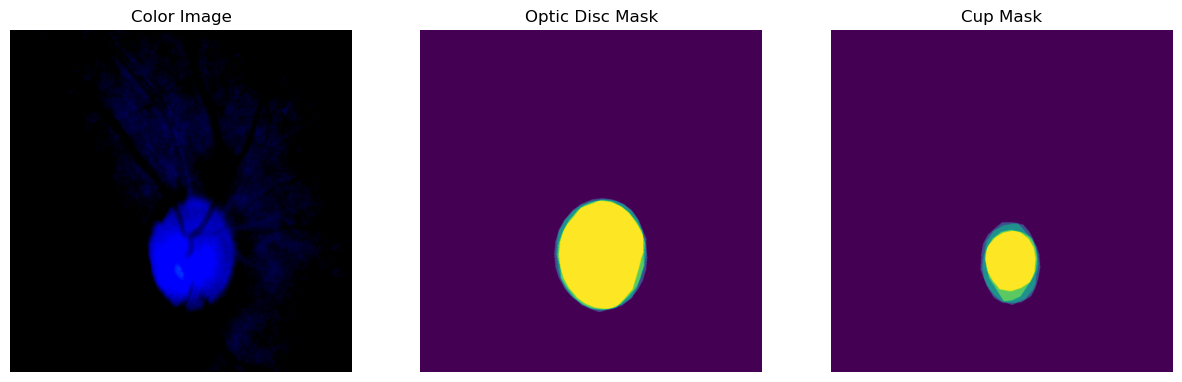

In [36]:
# plot sample image and mask
img, od_mask, cup_mask = next(iter(dataloader))

# print shape
print(f'Image shape: {img.shape}')
print(f'Optic Disc Mask shape: {od_mask.shape}')
print(f'Cup Mask shape: {cup_mask.shape}')

# print min and max values
print(f'Image min: {img.min().item()} Image max: {img.max().item()}')
print(f'Optic Disc Mask min: {od_mask.min().item()} Optic Disc Mask max: {od_mask.max().item()}')
print(f'Cup Mask min: {cup_mask.min().item()} Cup Mask max: {cup_mask.max().item()}')

# plot image and mask
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img[0].detach().cpu().squeeze().permute(1, 2, 0))
ax[0].set_title('Color Image')
ax[0].axis('off')
ax[1].imshow(od_mask[0].detach().cpu().numpy().squeeze())
ax[1].set_title('Optic Disc Mask')
ax[1].axis('off')
ax[2].imshow(cup_mask[0].detach().cpu().numpy().squeeze())
ax[2].set_title('Cup Mask')
ax[2].axis('off')

plt.show()



In [8]:
def dice_coeff(y_true, y_pred):
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum()
    return (2. * intersection + 1e-15) / (union + 1e-15)

In [9]:
def train_epoch(model, optim, criterion, dataloader):
    model.train()
    train_loss = 0
    train_dice = 0
    for idx, (img, od_mask, cup_mask) in enumerate(dataloader):
        optim.zero_grad()
        out = model(img)
        out = torch.sigmoid(out)
        od_mask_out = out[:, 0, :, :].unsqueeze(1)
        cup_mask_out = out[:, 1, :, :].unsqueeze(1)
        loss = (criterion(od_mask_out, od_mask) + criterion(cup_mask_out, cup_mask)) / 2
        loss.backward()
        optim.step()

        train_loss += loss.item()
        dice = (dice_coeff(od_mask_out, od_mask) + dice_coeff(cup_mask_out, cup_mask)) / 2
        train_dice += dice.item()
        print(f'Batch: {idx+1}/{len(dataloader)} Loss: {loss.item():.4f}, Dice: {dice:.4f}', end='\r')
    print()
    return train_loss / len(dataloader), train_dice / len(dataloader)

def eval(model, criterion, dataloader):
    model.eval()
    eval_loss = 0
    eval_dice = 0
    with torch.no_grad():
        for idx, (img, od_mask, cup_mask) in enumerate(dataloader):
            out = model(img)
            out = torch.sigmoid(out)
            od_mask_out = out[:, 0, :, :].unsqueeze(1)
            cup_mask_out = out[:, 1, :, :].unsqueeze(1)
            loss = (criterion(od_mask_out, od_mask) + criterion(cup_mask_out, cup_mask)) / 2

            eval_loss += loss.item()
            dice = (dice_coeff(od_mask_out, od_mask) + dice_coeff(cup_mask_out, cup_mask)) / 2
            eval_dice += dice.item()
            print(f'Batch: {idx+1}/{len(dataloader)} Loss: {loss.item():.4f}, Dice: {dice:.4f}', end='\r')
    return eval_loss / len(dataloader), eval_dice / len(dataloader)

In [10]:
EPOCHS = 10

In [11]:
# create model
# model = UNet(in_channels=3, out_channels=2).cuda()
model = AttentionUNet(in_channels=3, out_channels=2).cuda()

# create optimizer
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

# # binary cross entropy loss
# criterion = torch.nn.BCEWithLogitsLoss()

# # dice loss is 1 - dice coefficient
criterion = lambda x, y: 1 - dice_coeff(x, y)

In [12]:
# train model
for epoch in range(EPOCHS):
    print(f'Epoch: {epoch+1}/{EPOCHS}' )
    train_loss, train_dice  = train_epoch(model, optim, criterion, dataloader)
    print(f'Avg train Loss: {train_loss:.4f}, Avg train Dice: {train_dice:.4f}')
    print('-'*50)


Epoch: 1/10


/home/maheshda/miniconda3/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Batch: 50/50 Loss: 0.9989, Dice: 0.0011
Avg train Loss: 0.9989, Avg train Dice: 0.0011
--------------------------------------------------
Epoch: 2/10
Batch: 50/50 Loss: 0.9980, Dice: 0.0020
Avg train Loss: 0.9987, Avg train Dice: 0.0013
--------------------------------------------------
Epoch: 3/10
Batch: 50/50 Loss: 0.9987, Dice: 0.0013
Avg train Loss: 0.9986, Avg train Dice: 0.0014
--------------------------------------------------
Epoch: 4/10
Batch: 50/50 Loss: 0.9977, Dice: 0.0023
Avg train Loss: 0.9985, Avg train Dice: 0.0015
--------------------------------------------------
Epoch: 5/10
Batch: 50/50 Loss: 0.9983, Dice: 0.0017
Avg train Loss: 0.9984, Avg train Dice: 0.0016
--------------------------------------------------
Epoch: 6/10
Batch: 50/50 Loss: 0.9984, Dice: 0.0016
Avg train Loss: 0.9982, Avg train Dice: 0.0018
--------------------------------------------------
Epoch: 7/10
Batch: 50/50 Loss: 0.9976, Dice: 0.0024
Avg train Loss: 0.9981, Avg train Dice: 0.0019
-------------

In [13]:
test_data, test_file_names = load_data(train=False)
test_dataset = SegmentationDataset(test_data, test_file_names)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)


In [14]:
# evaluate model on test set
test_loss, test_dice = eval(model, criterion, test_dataloader)
print(f'Avg test Loss: {test_loss:.4f}, Avg test Dice: {test_dice:.4f}')

Avg test Loss: 0.9980, Avg test Dice: 0.0020


In [15]:
# add predictions to test data
test_data['OD_mask_pred'] = {}
test_data['cup_mask_pred'] = {}
model.eval()
with torch.no_grad():
    for idx, (img, od_mask, cup_mask) in enumerate(test_dataloader):
        out = model(img)
        out = torch.sigmoid(out)
        od_mask_pred = out[:, 0, :, :].unsqueeze(1)
        cup_mask_pred = out[:, 1, :, :].unsqueeze(1)
        test_data['OD_mask_pred'][test_file_names[idx]] = od_mask_pred.squeeze().detach().cpu().numpy().squeeze()
        test_data['cup_mask_pred'][test_file_names[idx]] = cup_mask_pred.squeeze().detach().cpu().numpy().squeeze()

Image shape: (1053, 1227, 3), Optic Disc Mask shape: (1053, 1227), Cup Mask shape: (1053, 1227), Predicted Optic Disc Mask shape: (512, 512), Predicted Cup Mask shape: (512, 512)


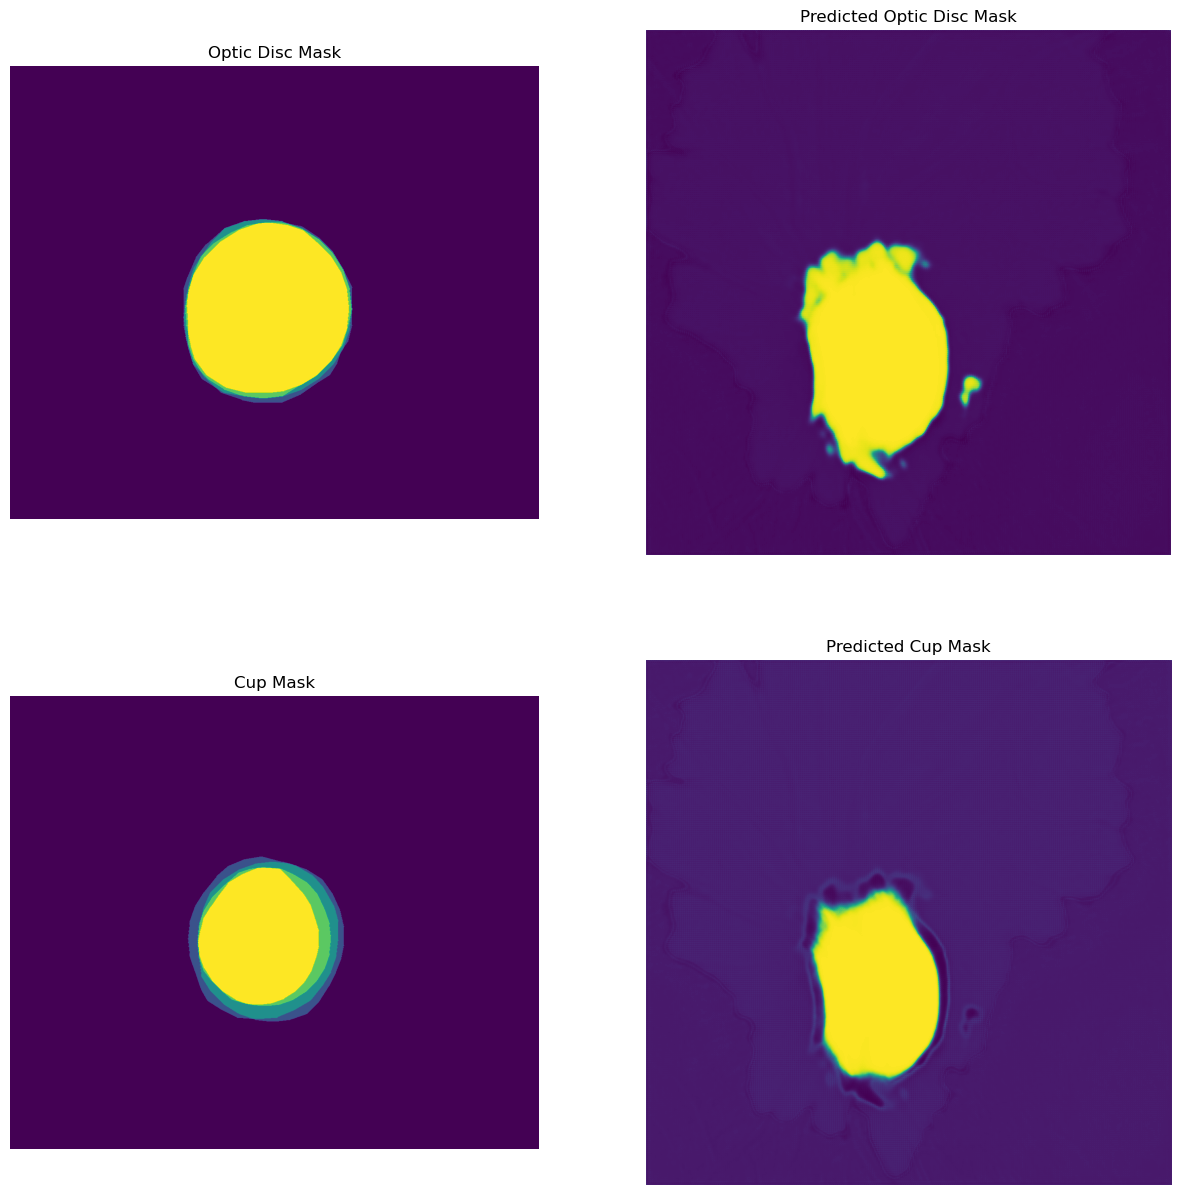

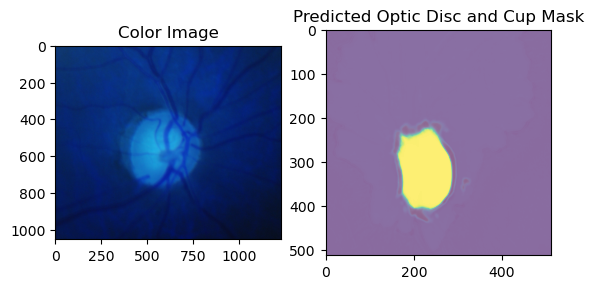

In [20]:
# plot sample image and mask, and predicted mask

idx = np.random.randint(0, len(test_data['images']))
img = test_data['images'][test_file_names[idx]]
od_mask = test_data['OD_mask'][test_file_names[idx]]
cup_mask = test_data['cup_mask'][test_file_names[idx]]
od_mask_pred = test_data['OD_mask_pred'][test_file_names[idx]]
cup_mask_pred = test_data['cup_mask_pred'][test_file_names[idx]]

print(f'Image shape: {img.shape}, Optic Disc Mask shape: {od_mask.shape}, Cup Mask shape: {cup_mask.shape}, Predicted Optic Disc Mask shape: {od_mask_pred.shape}, Predicted Cup Mask shape: {cup_mask_pred.shape}')

# plot color image
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.imshow(od_mask)
plt.title('Optic Disc Mask')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(od_mask_pred)
plt.title('Predicted Optic Disc Mask')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(cup_mask)
plt.title('Cup Mask')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(cup_mask_pred)
plt.title('Predicted Cup Mask')
plt.axis('off')
plt.show()

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Color Image')
plt.subplot(1, 2, 2)
plt.imshow(od_mask_pred, alpha=0.1)
plt.imshow(cup_mask_pred, alpha=0.6 )
plt.title('Predicted Optic Disc and Cup Mask')
plt.show()

In [ ]:
# # load random image and mask
# idx = np.random.randint(0, len(data['images']))
# img = data['images'][file_names[idx]]
# od_mask = data['OD_mask'][file_names[idx]]
# cup_mask = data['cup_mask'][file_names[idx]]

# img = img[int(img.shape[0]*0.2):int(img.shape[0]*0.8), int(img.shape[1]*0.2):int(img.shape[1]*0.8)]
# od_mask = od_mask[int(od_mask.shape[0]*0.2):int(od_mask.shape[0]*0.8), int(od_mask.shape[1]*0.2):int(od_mask.shape[1]*0.8)]
# cup_mask = cup_mask[int(cup_mask.shape[0]*0.2):int(cup_mask.shape[0]*0.8), int(cup_mask.shape[1]*0.2):int(cup_mask.shape[1]*0.8)]


# # Convert the image to LAB color space
# lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# # Split the LAB image into channels
# l, a, b = cv2.split(lab)

# # Apply CLAHE to the L channel
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
# clahe_l = clahe.apply(l)

# # Merge the CLAHE-enhanced L channel with the original A and B channels
# lab_clahe = cv2.merge((clahe_l, a, b))

# # Convert the LAB image back to RGB color space
# clahe_rgb = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

# # Median Blur
# final_img = cv2.medianBlur(clahe_rgb, 5)

# # plot color image
# fig, ax = plt.subplots(1, 4, figsize=(20, 5))
# ax[0].imshow(img)
# ax[0].set_title('Color Image')
# ax[0].axis('off')
# ax[1].imshow(final_img)
# ax[1].set_title('CLAHE + Median Blur Color Image')
# ax[1].axis('off')
# ax[2].imshow(od_mask)
# ax[2].set_title('Optic Disc Mask')
# ax[2].axis('off')
# ax[3].imshow(cup_mask)
# ax[3].set_title('Cup Mask')
# ax[3].axis('off')
# plt.show()

In [ ]:
# def clahe_medianblur(img):
#     # Convert the image to LAB color space
#     lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

#     # Split the LAB image into channels
#     l, a, b = cv2.split(lab)

#     # Apply CLAHE to the L channel
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
#     clahe_l = clahe.apply(l)

#     # Merge the CLAHE-enhanced L channel with the original A and B channels
#     lab_clahe = cv2.merge((clahe_l, a, b))

#     # Convert the LAB image back to RGB color space
#     clahe_rgb = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

#     # Median Blur
#     final_img = cv2.medianBlur(clahe_rgb, 5)

#     return final_img

# for file_name in file_names:
#     data['images'][file_name] = clahe_medianblur(data['images'][file_name])

In [1]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

In [2]:
torch.cuda.set_device(0)

In [5]:
model = resnet50(pretrained=True)
for name, param in model.named_parameters():
    print(name, param.requires_grad)

/home/maheshda/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maheshda/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.0.conv3.weight True
layer1.0.bn3.weight True
layer1.0.bn3.bias True
layer1.0.downsample.0.weight True
layer1.0.downsample.1.weight True
layer1.0.downsample.1.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer1.1.conv3.weight True
layer1.1.bn3.weight True
layer1.1.bn3.bias True
layer1.2.conv1.weight True
layer1.2.bn1.weight True
layer1.2.bn1.bias True
layer1.2.conv2.weight True
layer1.2.bn2.weight True
layer1.2.bn2.bias True
layer1.2.conv3.weight True
layer1.2.bn3.weight True
layer1.2.bn3.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.conv3.weight True
